Epoch 0: Accuracy 0.000, Average Loss 2.303356261253357
Epoch 0: Accuracy 0.000, Average Loss 2.3030056953430176

Epoch 1: Accuracy 0.013, Average Loss 2.0040698528289793
Epoch 1: Accuracy 0.015, Average Loss 1.9682587504386901

Epoch 2: Accuracy 0.082, Average Loss 1.823970239162445
Epoch 2: Accuracy 0.095, Average Loss 1.7625863075256347

Epoch 3: Accuracy 0.145, Average Loss 1.6052672815322877
Epoch 3: Accuracy 0.176, Average Loss 1.523538339138031

Epoch 4: Accuracy 0.197, Average Loss 1.526534423828125
Epoch 4: Accuracy 0.244, Average Loss 1.4236721038818358

Epoch 5: Accuracy 0.230, Average Loss 1.4655852580070496
Epoch 5: Accuracy 0.283, Average Loss 1.3637203574180603

Epoch 6: Accuracy 0.278, Average Loss 1.3823938083648681
Epoch 6: Accuracy 0.324, Average Loss 1.2920755743980408

Epoch 7: Accuracy 0.297, Average Loss 1.3766446018218994
Epoch 7: Accuracy 0.335, Average Loss 1.2921541690826417

Epoch 8: Accuracy 0.347, Average Loss 1.2874274826049805
Epoch 8: Accuracy 0.397, Av

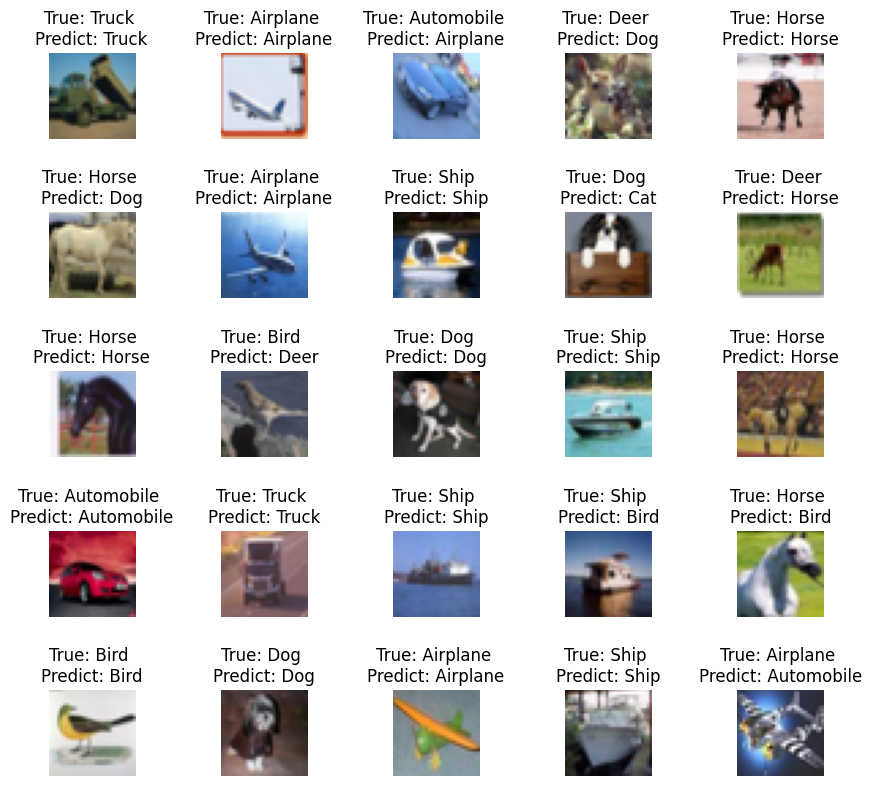

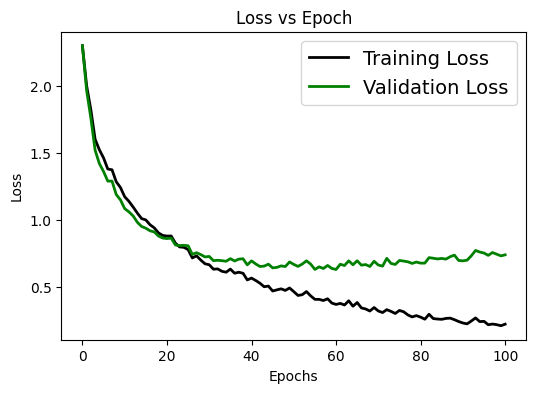

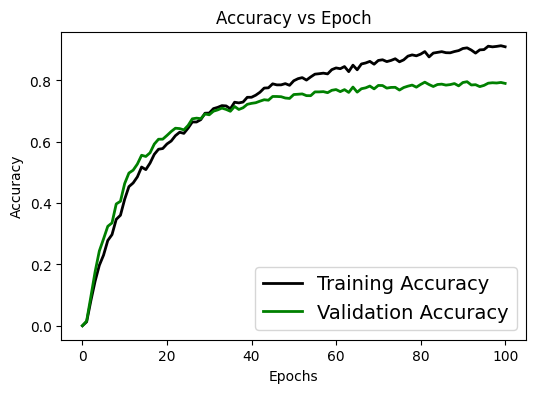

In [12]:
# train the model

from PIL import Image

import numpy as np
import mlx.core as mx
import mlx.nn as nn
import matplotlib.pyplot as plt

from alpineml import Network
from alpineml.layer.reshape import Flatten
from alpineml.layer.shim import MLX
from alpineml.optim import SGD
from alpineml.function.activation import leaky_relu, softmax
from alpineml.function.loss import CrossEntropyLoss, cross_entropy_loss
from alpineml.layer.core import Linear, Activation
from dataset import get_cifar10


# Visualize
def viz_sample_predictions(network, test_data, label_map, rows=5, cols=5, figsize=(10, 10)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize, num="Sample Predictions")
    axes = axes.reshape(-1)  # flatten

    test_data = test_data.to_buffer().shuffle()
    def sample_random():
        for j in np.arange(0, rows * cols):
            i = np.random.randint(0, len(test_data))
            x = mx.array(test_data[i]['image'])
            y = mx.array(test_data[i]['label'])
            y_pred = network.forward(x[mx.newaxis, ...])

            sample = np.array(255 * x)
            if sample.shape[2] == 3:
                image = Image.fromarray(sample.astype('uint8'))
            else:
                image = Image.fromarray(sample.reshape(sample.shape[0], sample.shape[1]))

            raw_label = mx.argmax(y).item()
            label = label_map[raw_label]

            raw_pred = mx.argmax(y_pred).item()
            pred = label_map[raw_pred]

            axes[j].imshow(image)
            axes[j].set_title(f"True: {label} \nPredict: {pred}")
            axes[j].axis('off')
            plt.subplots_adjust(wspace=1)

    def on_key(event):
        if event.key == ' ':
            sample_random()
            fig.show()

    fig.canvas.mpl_connect('key_press_event', on_key)

    sample_random()


def viz_history(history, figsize=(6, 4)):
    plt.figure(figsize=figsize, num="Loss Curves")
    plt.plot(history['epoch'], history['train_loss'], 'black', linewidth=2.0)
    plt.plot(history['epoch'], history['test_loss'], 'green', linewidth=2.0)
    plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
    plt.xlabel('Epochs', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.title('Loss vs Epoch', fontsize=12)

    plt.figure(figsize=figsize, num="Accuracy Curves")
    plt.plot(history['epoch'], history['train_accuracy'], 'black', linewidth=2.0)
    plt.plot(history['epoch'], history['test_accuracy'], 'green', linewidth=2.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
    plt.xlabel('Epochs', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.title('Accuracy vs Epoch', fontsize=12)


# Evaluate
def eval_model(model, dataset, epoch=None):
    mean_losses = []
    accuracies = []
    predictions = []

    for batch in dataset:
        x_batch = mx.array(batch["image"])
        y_batch = mx.array(batch["label"])

        y_pred = model.forward(x_batch)
        predictions.append(y_pred)

        loss = optimizer.loss_fn(y_pred, y_batch)
        mean_loss = mx.mean(mx.sum(loss, axis=1))
        mean_losses.append(mean_loss.item())

        if isinstance(optimizer.loss_fn, CrossEntropyLoss):
            y_pred = softmax(y_pred)

        errors = mx.sum(mx.abs(y_batch - mx.round(y_pred)), axis=1)
        accuracy = mx.sum(errors == 0) / y_batch.shape[0]
        accuracies.append(accuracy.item())

    mean_loss = sum(mean_losses) / len(mean_losses)
    accuracy = sum(accuracies) / len(accuracies)
    predictions = np.concatenate(predictions)

    dataset.reset()

    if epoch is not None:
        print(f"Epoch {epoch}: Accuracy {accuracy:.3f}, Average Loss {mean_loss}")
    else:
        print(f"Accuracy {accuracy:.3f}, Average Loss {mean_loss}")
        print(f"Accuracy {accuracy:.3f}, Average Loss {mean_loss}")

    return predictions, accuracy, mean_loss


def train(train_data, epochs, batch_size=1, test_data=None, cb=None):
    batched_train_data = train_data.batch(batch_size)
    batched_test_data = test_data.batch(batch_size)

    def train_epoch():
        for batch in batched_train_data:
            x_batch = mx.array(batch["image"])
            y_batch = mx.array(batch["label"])
            optimizer.step(x_batch, y_batch)
        batched_train_data.reset()

    history = {"epoch": [], "train_loss": [], "test_loss": [], "train_accuracy": [], "test_accuracy": []}

    _, train_accuracy, train_loss = eval_model(network, batched_train_data, epoch=0)
    _, test_accuracy, test_loss = eval_model(network, batched_test_data, epoch=0)
    print()
    history["epoch"].append(0)
    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["train_accuracy"].append(train_accuracy)
    history["test_accuracy"].append(test_accuracy)

    for epoch in range(1, epochs + 1):
        train_epoch()

        _, train_accuracy, train_loss = eval_model(network, batched_train_data, epoch=epoch)
        _, test_accuracy, test_loss = eval_model(network, batched_test_data, epoch=epoch)
        print()
        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["train_accuracy"].append(train_accuracy)
        history["test_accuracy"].append(test_accuracy)

    test_data.reset()
    eval_model(network, batched_test_data)
    print()

    viz_sample_predictions(network, test_data, label_map)
    viz_history(history)
    plt.show()


train_data, test_data = get_cifar10(static=False)
label_map = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

network = Network(input_shape=(32, 32, 3))

# conv block 1
network.add_layer(MLX(nn.Conv2d(in_channels=3, out_channels=96, kernel_size=7)))
network.add_layer(Activation(leaky_relu))
network.add_layer(MLX(nn.MaxPool2d(2)))
# conv block 2
network.add_layer(MLX(nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3)))
network.add_layer(Activation(leaky_relu))
network.add_layer(MLX(nn.MaxPool2d(2)))
# feed forward
network.add_layer(Flatten())
network.add_layer(Linear(1024))
network.add_layer(Activation(leaky_relu))
network.add_layer(Linear(10))

optimizer = SGD(eta=0.05, momentum=0.9, weight_decay=0.0005)
optimizer.bind_loss_fn(cross_entropy_loss)
optimizer.bind_network(network)

train(train_data, epochs=100, batch_size=1000, test_data=test_data)

In [21]:
# save and write checkpoint
checkpoint = network.save()
print(checkpoint.params)
checkpoint.write("checkpoints/simple_conv.pb")

[{'weight': <alpineml.layer.Layer.Layer.Parameter object at 0x10ddbd150>, 'bias': <alpineml.layer.Layer.Layer.Parameter object at 0x1647ff850>}, {}, {}, {'weight': <alpineml.layer.Layer.Layer.Parameter object at 0x16117dd60>, 'bias': <alpineml.layer.Layer.Layer.Parameter object at 0x11caca300>}, {}, {}, {}, {'W': <alpineml.layer.Layer.Layer.Parameter object at 0x10792b690>, 'b': <alpineml.layer.Layer.Layer.Parameter object at 0x10792a5f0>}, {}, {'W': <alpineml.layer.Layer.Layer.Parameter object at 0x161310600>, 'b': <alpineml.layer.Layer.Layer.Parameter object at 0x164362bd0>}]


In [23]:
# load checkpoint
network_copy = Network(input_shape=(32, 32, 3))

# conv block 1
network_copy.add_layer(MLX(nn.Conv2d(in_channels=3, out_channels=96, kernel_size=7)))
network_copy.add_layer(Activation(leaky_relu))
network_copy.add_layer(MLX(nn.MaxPool2d(2)))
# conv block 2
network_copy.add_layer(MLX(nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3)))
network_copy.add_layer(Activation(leaky_relu))
network_copy.add_layer(MLX(nn.MaxPool2d(2)))
# feed forward
network_copy.add_layer(Flatten())
network_copy.add_layer(Linear(1024))
network_copy.add_layer(Activation(leaky_relu))
network_copy.add_layer(Linear(10))

network_copy.load(checkpoint)

In [24]:
# eval original and checkpoint to check they're equivalent
test_data.reset()
eval_model(network, test_data.batch(1))
print()

test_data.reset()
eval_model(network_copy, test_data.batch(1))
print()

Accuracy 0.790, Average Loss 0.7413075340743029

Accuracy 0.790, Average Loss 0.7413075340743029

